# Mapping digit-representations in the human primary somatosensory cortex and their layer-dependent functional connectivity at 7T.
## Analysis-stim

In this notebook, we are describing and, where possible, performing the analysis of this publication.

In [1]:
# basic
import glob
import itertools
import pandas as pd
import numpy as np
import os

# plotting
from nilearn import plotting
from scipy import ndimage
import matplotlib.cm as cm
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.pyplot as plt

# neuroimaging
from nilearn.connectome import ConnectivityMeasure
import nibabel as nb
from nibabel import load, save, Nifti1Image
import nipype.interfaces.fsl as fsl
import nilearn
import ants

# misc
from scipy.ndimage import morphology
from scipy import stats
from scipy import interpolate


%matplotlib inline

/home/sebastian/.local/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


220112-16:09:07,319 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.6.1


### Event-files

Let's start by generating the event-files for the stimulation runs. Because the same stimulation patterns were used for all runs, we can do this once for all subjects. However, we have to take care of the number of runs that individual participants have.

In [2]:
root = '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS'

subFolders = sorted(glob.glob(root + '/sub*'))
subs = [path.split('/')[-1] for path in subFolders]

In [5]:
modalities = ['BOLD', 'VASO']


In [5]:
folder = '/media/sebastian/Data/S1ANFUNCO/raw_data/derivatives/log-files'

for pattern in ['A','B']:
    file = glob.glob(f'{folder}/sub14_run*-mPTS_2x3ch_2019_SlowBlock_8TRs_t3_1{pattern}.log')

    f = open(file[0])

    df = pd.read_csv(f, skiprows=2, sep='\t', lineterminator='\n',
                         usecols=["Code", 'Time'])
    df.rename(columns={'Time': 'start_time','Code':'Type'}, inplace=True)
    
    df["start_time"] = pd.to_numeric(df["start_time"])

    first_pulse_time = df.at[1,'start_time']
    last_pulse_time = int(df.at[df.last_valid_index(),'start_time'])
    
    
    df['start_time'] = df['start_time'].sub(first_pulse_time) # normalize to first pulse-time
    df['start_time'] = df['start_time'].div(10000) # convert to seconds
    

    eventTypes = ['D2', 'D3', 'D4', 'Baseline']

    df = df.loc[df['Type'].str.contains('|'.join(eventTypes))]
    df.reset_index(drop = True, inplace=True)


    durations = [abs(df['start_time'][i]-df['start_time'][i+1]) for i in range(len(df['start_time'])-1)]
    durations.append(abs(df['start_time'].iloc[-1]-(last_pulse_time-first_pulse_time)/10000))

    df['duration'] = durations
    df['factor'] = np.ones(len(df['start_time']))

    
    for eventType in eventTypes:
        tmp = df.loc[df['Type'].str.contains(eventType)].drop(columns = ['Type']).astype(int)
        tmp.to_csv(f'{root}/derivatives/designFiles/stimulationPatterns/pattern{pattern}_{eventType}.txt', sep=' ', index=False, header=False)



In [49]:
folder = f'{root}/derivatives/logFiles'

logFiles = sorted(glob.glob(f'{folder}/*.log'))


for file in logFiles:
    fileName = file.split("/")[-1]
    subNumber = fileName[3:5]
    runNumber = fileName[9]
    
    if not subNumber.isnumeric():
        continue
    os.system(f'mkdir {root}/derivatives/designFiles/stimulationPatterns/sub-{subNumber}')
    f = open(file)

    df = pd.read_csv(f, skiprows=2, sep='\t', lineterminator='\n',
                         usecols=["Code", 'Time'])
    df.rename(columns={'Time': 'start_time','Code':'Type'}, inplace=True)
    
    df["start_time"] = pd.to_numeric(df["start_time"])

    first_pulse_time = df.at[1,'start_time']
    last_pulse_time = int(df.at[df.last_valid_index(),'start_time'])
    
    
    df['start_time'] = df['start_time'].sub(first_pulse_time) # normalize to first pulse-time
    df['start_time'] = df['start_time'].div(10000) # convert to seconds
    

    eventTypes = ['D1', 'D2', 'D3', 'D4', 'D5', 'Baseline']

    df = df.loc[df['Type'].str.contains('|'.join(eventTypes))]
    df.reset_index(drop = True, inplace=True)


    durations = [abs(df['start_time'][i]-df['start_time'][i+1]) for i in range(len(df['start_time'])-1)]
    durations.append(abs(df['start_time'].iloc[-1]-(last_pulse_time-first_pulse_time)/10000))

    df['duration'] = durations
    df['factor'] = np.ones(len(df['start_time']))

    
    for eventType in eventTypes:
        tmp = df.loc[df['Type'].str.contains(eventType)].drop(columns = ['Type']).astype(int)
        if not tmp.empty:
            tmp.to_csv(f'{root}/derivatives/designFiles/stimulationPatterns/sub-{subNumber}/sub-{subNumber}_ses-001_task-stim_run-00{runNumber}_{eventType}.txt', sep=' ', index=False, header=False)



## Prepare GLM

To automate the GLM, we prepared a template .fsf file and will loop through all participants to create their own. 

**take care**

In sub-12,  we stimulated all 5 fingers. Therefore, this subject has to handled differently and we created the .fsf files manually.

In [50]:
# Set this to the directory all of the sub### directories live in
root = '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS'


fsfDir = f"{root}/derivatives/designFiles/fsfs"

for sub in subs:
    
    for modality in ['BOLD', 'VASO']:
        print(modality)
        
        runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-stim*run-00*_cbv.nii.gz'))

        for run in runs:
            
            base = os.path.basename(run).rsplit('.', 2)[0][:-4]
            print(base)
            
            eventFile = f'{root}/{sub}/ses-001/events/{base}.txt'
            
            
            actualData = f'{root}/derivatives/{sub}/func/{base}_{modality}.nii.gz'
            
            
            runData = nb.load(actualData).get_fdata()
            nrVolumes = str(runData.shape[-1])
            
            print(nrVolumes)
#             if int(base[-1])%2 != 0:
#                 pattern = 'patternA'            
#             if int(base[-1])%2 == 0:
#                 pattern = 'patternB'
            
#             replacements = {'STIMPATTERN': pattern,'SUBJECT': sub, 'ROOT': root, 'MODALITY':modality, 'BASE': base, 'NRVOLUMES': nrVolumes}
            replacements = {'SUBJECT': sub, 'ROOT': root, 'MODALITY':modality, 'BASE': base, 'NRVOLUMES': nrVolumes}



            with open(f"{fsfDir}/stimulationDesignTemplate{modality}.fsf") as infile:
                with open(f"{fsfDir}/{base}_{modality}.fsf", 'w') as outfile:
                    for line in infile:
                        for src, target in replacements.items():
                            line = line.replace(src, target)
                        outfile.write(line)

  

BOLD
sub-02_ses-003_task-stim_run-001
406
sub-02_ses-003_task-stim_run-002
404
VASO
sub-02_ses-003_task-stim_run-001
404
sub-02_ses-003_task-stim_run-002
402
BOLD
sub-05_ses-002_task-stim_run-001
402
VASO
sub-05_ses-002_task-stim_run-001
400
BOLD
sub-06_ses-001_task-stim_run-001
400
VASO
sub-06_ses-001_task-stim_run-001
398
BOLD
sub-07_ses-001_task-stim_run-001
402
sub-07_ses-001_task-stim_run-002
402
VASO
sub-07_ses-001_task-stim_run-001
400
sub-07_ses-001_task-stim_run-002
400
BOLD
sub-09_ses-001_task-stim_run-001
402
VASO
sub-09_ses-001_task-stim_run-001
400
BOLD
sub-10_ses-001_task-stim_run-001
402
VASO
sub-10_ses-001_task-stim_run-001
400
BOLD
sub-12_ses-001_task-stim_run-001
328
sub-12_ses-001_task-stim_run-002
344
sub-12_ses-001_task-stim_run-003
342
sub-12_ses-001_task-stim_run-004
350
VASO
sub-12_ses-001_task-stim_run-001
326
sub-12_ses-001_task-stim_run-002
342
sub-12_ses-001_task-stim_run-003
340
sub-12_ses-001_task-stim_run-004
350
BOLD
sub-15_ses-001_task-stim_run-001
402


### Run first level GLM

In [51]:
import glob
import os


fsfDir = f"{root}/derivatives/designFiles/fsfs"


feats = sorted(glob.glob(f'{fsfDir}/*.fsf'))

# for feat1, feat2 in zip(feats[8::2],feats[9::2]):
#     print(f'1: {feat1}')
#     print(f'2: {feat2}')
#     os.system(f'feat {feat1} & feat {feat2}')

In [106]:
for sub in ['sub-02', 'sub-12']:
    feats = sorted(glob.glob(f'{fsfDir}/{sub}_*.fsf'))
    for feat1, feat2 in zip(feats[::2],feats[1::2]):
        print(f'1: {feat1}')
        print(f'2: {feat2}')
        os.system(f'feat {feat1} & feat {feat2}')

1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-02_ses-003_task-stim_run-001_BOLD.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-02_ses-003_task-stim_run-001_VASO.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-02_ses-003_task-stim_run-002_BOLD.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-02_ses-003_task-stim_run-002_VASO.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-12_ses-001_task-stim_run-001_BOLD.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-12_ses-001_task-stim_run-001_VASO.fsf
1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/sub-12_ses-001_task-stim_run-002_BOLD.fsf
2: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/designFiles/fsfs/su

### Prepare second level GLMs

In [111]:
subs[6:7]

['sub-12']

In [117]:
for sub in subs[6:7]:
    feats = sorted(glob.glob(f'{root}/derivatives/{sub}/func/*.feat'))

In [118]:
feats

['/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-12/func/sub-12_ses-001_task-stim_run-001_BOLD.feat',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-12/func/sub-12_ses-001_task-stim_run-001_VASO.feat',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-12/func/sub-12_ses-001_task-stim_run-002_BOLD.feat',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-12/func/sub-12_ses-001_task-stim_run-002_VASO.feat',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-12/func/sub-12_ses-001_task-stim_run-003_BOLD.feat',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-12/func/sub-12_ses-001_task-stim_run-003_VASO.feat',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-12/func/sub-12_ses-001_task-stim_run-004_BOLD.feat',
 '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-12/func/sub-12_ses-001_task-stim_run-

In [119]:
%%bash -s "{" ".join(feats)}" 

for folder in $1
do

cd $folder
mkdir reg
cp $FSLDIR/etc/flirtsch/ident.mat reg/example_func2standard.mat
cp mean_func.nii.gz reg/standard.nii.gz

done

mkdir: cannot create directory ‘reg’: File exists
mkdir: cannot create directory ‘reg’: File exists
mkdir: cannot create directory ‘reg’: File exists
mkdir: cannot create directory ‘reg’: File exists
mkdir: cannot create directory ‘reg’: File exists
mkdir: cannot create directory ‘reg’: File exists
mkdir: cannot create directory ‘reg’: File exists
mkdir: cannot create directory ‘reg’: File exists


['sub-18']

## Define ROIs

### Upsample statistical maps

In [126]:
subs

['sub-02',
 'sub-05',
 'sub-06',
 'sub-07',
 'sub-09',
 'sub-10',
 'sub-12',
 'sub-15',
 'sub-16',
 'sub-17',
 'sub-18']

In [129]:
for sub in subs[:1]:
    print(sub)
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-stim_run-00*_cbv.nii.gz'))
    
    if len(runs) == 1:

        base = os.path.basename(run[0]).rsplit('.', 2)[0][:-4]
        print(base)
        
        for modality in modalities:
            
            for copeNr in range(1,7):
                os.system(f'c3d {root}/derivatives/{sub}/func/{base}_{modality}.feat/stats/zstat{copeNr}.nii.gz -resample 500x500x100% -interpolation Cubic -o {root}/derivatives/{sub}/func/{base}_{modality}.feat/stats/zstat{copeNr}_scaled.nii.gz')     

    if len(runs) > 1:
        
        for modality in modalities:

            for copeNr in range(1,7):
                
                os.system(f'c3d {root}/derivatives/{sub}/func/{sub}_ses-003_task-stim_secondLevel_{modality}.gfeat/cope{copeNr}.feat/stats/zstat1.nii.gz -resample 500x500x100% -interpolation Cubic -o {root}/derivatives/{sub}/func/{sub}_ses-003_task-stim_secondLevel_{modality}.gfeat/cope{copeNr}.feat/stats/zstat1_scaled.nii.gz')     

sub-02


In [140]:
modalities = ['BOLD', 'VASO']

for sub in subs:
    
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-stim_run-00*_cbv.nii.gz'))

    for run in runs:

        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        print(base)
        
        for modality in modalities:
            print(modality)
            
            for copeNr in range(1,7):
                os.system(f'c3d {root}/derivatives/{sub}/func/{base}_{modality}.feat/stats/zstat{copeNr}.nii.gz -resample 500x500x100% -interpolation Cubic -o {root}/derivatives/{sub}/func/{base}_{modality}.feat/stats/zstat{copeNr}_scaled.nii.gz')     

sub-02_ses-003_task-stim_run-001
BOLD
VASO
sub-02_ses-003_task-stim_run-002
BOLD
VASO
sub-05_ses-002_task-stim_run-001
BOLD
VASO
sub-06_ses-001_task-stim_run-001
BOLD
VASO
sub-07_ses-001_task-stim_run-001
BOLD
VASO
sub-07_ses-001_task-stim_run-002
BOLD
VASO
sub-09_ses-001_task-stim_run-001
BOLD
VASO
sub-10_ses-001_task-stim_run-001
BOLD
VASO
sub-12_ses-001_task-stim_run-001
BOLD
VASO
sub-12_ses-001_task-stim_run-002
BOLD
VASO
sub-12_ses-001_task-stim_run-003
BOLD
VASO
sub-12_ses-001_task-stim_run-004
BOLD
VASO
sub-15_ses-001_task-stim_run-001
BOLD
VASO
sub-15_ses-001_task-stim_run-002
BOLD
VASO
sub-15_ses-001_task-stim_run-003
BOLD
VASO
sub-16_ses-001_task-stim_run-001
BOLD
VASO
sub-16_ses-001_task-stim_run-002
BOLD
VASO
sub-16_ses-001_task-stim_run-003
BOLD
VASO
sub-17_ses-001_task-stim_run-001
BOLD
VASO
sub-17_ses-001_task-stim_run-002
BOLD
VASO
sub-17_ses-001_task-stim_run-003
BOLD
VASO
sub-18_ses-001_task-stim_run-001
BOLD
VASO
sub-18_ses-001_task-stim_run-002
BOLD
VASO
sub-18_ses-

In [105]:
modalities = ['BOLD', 'VASO']

for sub in ['sub-07']:
    
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-stim_run-00*_cbv.nii.gz'))

    for run in runs:

        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        print(base)
        
        for modality in modalities:
            print(modality)
            
            for copeNr in range(1,7):
                os.system(f'c3d {root}/derivatives/{sub}/func/{sub}_ses-001_task-stim_secondLevel_{modality}.gfeat/cope{copeNr}.feat/stats/zstat1.nii.gz -resample 500x500x100% -interpolation Cubic -o {root}/derivatives/{sub}/func/{sub}_ses-001_task-stim_secondLevel_{modality}.gfeat/cope{copeNr}.feat/stats/zstat1_scaled.nii.gz')     

sub-07_ses-001_task-stim_run-001
BOLD
VASO
sub-07_ses-001_task-stim_run-002
BOLD
VASO


Because not all subjects show reliable peaks in the VASO data, we selected the ROIs based on the BOLD activity. Here, we find the slice with highest zscores. In BOLD and VASO

In [131]:
runs

['/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/sub-05/ses-002/func/sub-05_ses-002_task-stim_run-001_cbv.nii.gz']

In [10]:
digits = ['D2','D3','D4']

In [11]:
for sub in subs:
    print(sub)
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-stim_run-00*_cbv.nii.gz'))
    
    if len(runs) == 1:

        base = os.path.basename(runs[0]).rsplit('.', 2)[0][:-4]
        print(base)
        
        for modality in modalities:

            for roi,copeNr in zip(digits, range(1,4)):
                zMap = nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.feat/stats/zstat{copeNr}_scaled.nii.gz').get_fdata()
                maxVal = 0
                MaxSlice = 0
                for sliceNr in range(0,zMap.shape[-1]):
                    if np.amax(zMap[:,:,sliceNr]) > maxVal:
                        maxVal = np.amax(zMap[:,:,sliceNr])
                        MaxSlice = sliceNr
                print(f'{roi} {modality} {MaxSlice}')

    if len(runs) > 1:
        
        for modality in modalities:

            for roi,copeNr in zip(digits, range(1,4)):
                zMapFile = glob.glob(f'{root}/derivatives/{sub}/func/{sub}_ses-00*_task-stim_secondLevel_{modality}.gfeat/cope{copeNr}.feat/stats/zstat1_scaled.nii.gz')[0]
                
                zMap = nb.load(zMapFile).get_fdata()
                maxVal = 0
                MaxSlice = 0
                for sliceNr in range(0,zMap.shape[-1]):
                    if np.amax(zMap[:,:,sliceNr]) > maxVal:
                        maxVal = np.amax(zMap[:,:,sliceNr])
                        MaxSlice = sliceNr
                print(f'{roi} {modality} {MaxSlice}')

sub-02
D2 BOLD 12
D3 BOLD 14
D4 BOLD 13
D2 VASO 12
D3 VASO 12
D4 VASO 11
sub-05
sub-05_ses-002_task-stim_run-001
D2 BOLD 11
D3 BOLD 12
D4 BOLD 18


KeyboardInterrupt: 

### Draw ROIs

Cases where we deviate from drawing ROIs in the slice with the highstest z-score are shown and discussed below.

Subjects where this is the case are:

sub-02 D4 - looks like a vessel. We chose the closest logical slice.


sub-05 D4 - looks like a vessel. We chose the closest logical slice.


sub-06 NONE


sub-07 D4 - looks like a vessel. We chose the closest logical slice.


sub-09 D2 - isolated small blob. We chose the closest logical slice.


sub-10 D2 - looks like a vessel. We chose the closest logical slice.


sub-10 D4 - looks like a vessel. We chose the closest logical slice.


sub-12 D4 - looks like a vessel. We chose the closest logical slice.


sub-15 D4 - looks like a vessel. We chose the closest logical slice.


sub-16 D3 - looks like a vessel. We chose the closest logical slice.


sub-17 D4 - peak is in very small custer. We chose the closest slice with clearer activity


sub-18 NONE


### Generate layers

In [122]:
for sub in ['sub-05']:
    
    for digit in digits:
        
        folder = f'{root}/derivatives/{sub}/anat'
        
        os.system(f'mkdir {folder}/digitROIs')
        
        os.system(f'LN2_LAYERS -rim {root}/derivatives/manualSteps/{sub}/{sub}_{digit}rim.nii -nr_layers 11 -equivol -output {folder}/digitROIs/{sub}_{digit}_11')
#         os.system(f'LN2_LAYERS -rim {root}/derivatives/manualSteps/{sub}/{sub}_{digit}rim.nii -nr_layers 3 -equivol -output {folder}/digitROIs/{sub}_{digit}_03')


check how many layers were defined

In [15]:
digits

['D2', 'D3', 'D4']

In [17]:
for sub in ['sub-02']:
    
    rimFolder = f'{root}/derivatives/manualSteps/{sub}'
    outFolder = f'{root}/derivatives/{sub}/anat'
    
    for digit in digits:
        for nrLayers in [12, 3]:
            os.system(f'LN2_LAYERS -rim {rimFolder}/{sub}_{digit}rim.nii -nr_layers {nrLayers} -equivol -output {outFolder}/{sub}_{digit}_{nrLayers}')

In [6]:
%%bash -s "{" ".join(subs)}" "$root"

List1=$1

subsList=($List1)

len=${#subsList[@]}
# len=1

for (( j=0; j<$len; j++ ))
do

cd $2/derivatives/${subsList[$j]}/anat/


for digit in D2 D3 D4
do
LN2_LAYERS -rim ''$2'/derivatives/manualSteps/'${subsList[$j]}'/'${subsList[$j]}'_'$digit'rim.nii' -nr_layers 12 -equivol -output ''${subsList[$j]}'_'$digit'_12'
LN2_LAYERS -rim ''$2'/derivatives/manualSteps/'${subsList[$j]}'/'${subsList[$j]}'_'$digit'rim.nii' -nr_layers 3 -equivol -output ''${subsList[$j]}'_'$digit'_3'


done
done

LAYNII v2.0.0          
Compiled for Linux 64  
LN2_LAYERS

    File name: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/manualSteps/sub-02/sub-02_D2rim.nii
    Image details: 550 X | 350 Y | 21 Z | 1 T 
    Voxel size = 0.150617 x 0.150617 x 1.29
    Datatype = 512

  Nr. layers: 12

  Start growing from inner GM (WM-facing border)...

  Start growing from outer GM...

  Start layering (equi-distant)...
    Writing output as:
      sub-02_D2_12_metric_equidist.nii
    Writing output as:
      sub-02_D2_12_layers_equidist.nii

  Start finding middle gray matter (equi-distant)...
    Writing output as:
      sub-02_D2_12_midGM_equidist.nii

  Start equi-volume stage...

  Start computing equi-volume factors...

  Start smoothing equi-volume transitions...
    Iteration: 100/100

  Start final layering...
    Writing output as:
      sub-02_D2_12_layers_equivol.nii
    Writing output as:
      sub-02_D2_12_metric_equivol.nii

  Start finding middle gray matter (equi

In [429]:
%%bash

/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-17/anat/sub-17_D3_3_layers_equidist.nii
LN2_LAYERS -rim '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/manualSteps/sub-17/sub-17_D3rim.nii.gz' -nr_layers 12 -equivol -output '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-17/anat/sub-17_D3_12'
LN2_LAYERS -rim '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/manualSteps/sub-17/sub-17_D3rim.nii.gz' -nr_layers 3  -equivol -output '/media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-17/anat/sub-17_D3_3'


LAYNII v2.0.0          
Compiled for Linux 64  
LN2_LAYERS

    File name: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/manualSteps/sub-17/sub-17_D3rim.nii.gz
    Image details: 525 X | 350 Y | 21 Z | 1 T 
    Voxel size = 0.150617 x 0.150617 x 1.29
    Datatype = 512

  Nr. layers: 12

  Start growing from inner GM (WM-facing border)...

  Start growing from outer GM...

  Start layering (equi-distant)...
    Writing output as:
      /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-17/anat/sub-17_D3_12_metric_equidist.nii
    Writing output as:
      /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-17/anat/sub-17_D3_12_layers_equidist.nii

  Start finding middle gray matter (equi-distant)...
    Writing output as:
      /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-17/anat/sub-17_D3_12_midGM_equidist.nii

  Start equi-volume stage...

  Start computing equi-volume factors...

  Start smoothi

bash: line 1: /media/sebastian/Data/S1ANFUNCO/raw_data/S1ANFUNCO_BIDS/derivatives/sub-17/anat/sub-17_D3_3_layers_equidist.nii: Permission denied


### voxel counts per ROI and Layer

To make sure that we do not bias our analyses towards a given ROI or layer, we check whether the ROIs are somewhat equally sized.

look at an ROI with 3 layers


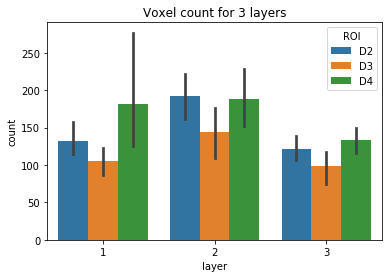

look at an ROI with 12 layers


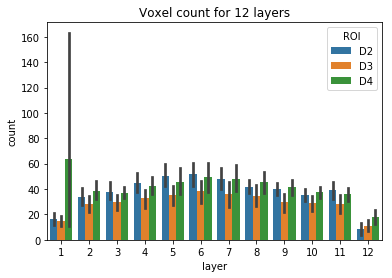

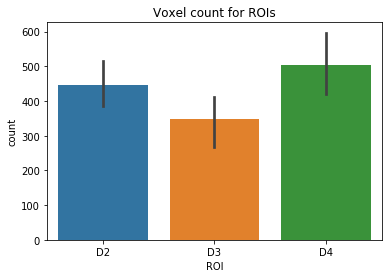

In [7]:

nrLayersList = [3, 12]
modalities = ['BOLD', 'VASO']
digits = ['D2','D3','D4']


for nrLayers in nrLayersList:
    print(f'look at an ROI with {nrLayers} layers')
    subList = []
    voxelList = []
    roiList = []
    layerList = []

    for sub in subs: 
        for roi in digits:
            mask = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{roi}_{nrLayers}_layers_equivol.nii').get_fdata()


            for j in range(1,nrLayers+1):  # Compute bin averages
                layerRoi = mask == j

                nonZero = np.count_nonzero(layerRoi)
                subList.append(sub)
                voxelList.append(nonZero)
                roiList.append(roi)
                layerList.append(j)

    voxelCounts = pd.DataFrame({'subject': subList, 'ROI': roiList, 'count': voxelList, 'layer':layerList})            

    plt.figure()
    sns.barplot(data=voxelCounts, x='layer',y='count',hue='ROI')
    plt.title(f'Voxel count for {nrLayers} layers')
    plt.show()


subList = []
voxelList = []
roiList = []
layerList = []    
    
for sub in subs: 
    for roi in digits:
        mask = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{roi}_{nrLayers}_layers_equivol.nii').get_fdata()


        nonZero = np.count_nonzero(mask)
        subList.append(sub)
        voxelList.append(nonZero)
        roiList.append(roi)
        layerList.append(j)    

voxelCounts = pd.DataFrame({'subject': subList, 'ROI': roiList, 'count': voxelList, 'layer':layerList})            

plt.figure()
sns.barplot(data=voxelCounts, x='ROI',y='count')
plt.title(f'Voxel count for ROIs')
plt.show()

## Extract z-scores

### Digit vs digits

In [9]:
subList = []
dataList = []
modalityList = []
layerList = []
digitList = []
roiList = []


digitsMaps = {'D2': 1, 'D3': 2, 'D4': 3}
digits = ['D2', 'D3', 'D4']



for sub in subs:    
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-stim_run-00*_cbv.nii.gz'))

    for run in runs:

        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        print(base)
        
        for modality in ['BOLD','VASO']:
            
                
            for roi in digitsMaps.keys():
                mask = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{roi}_12_layers_equivol.nii').get_fdata()
                
                for digit in digits:
                    
                    data = nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.feat/stats/zstat{digitsMaps[digit]}_scaled.nii.gz').get_fdata()



                    for j in range(1,13):  # Compute bin averages
                        
                        
                        layerRoi = mask == j
                        
                        mask_mean = np.mean(data[layerRoi.astype(bool)])

                        subList.append(sub)
                        dataList.append(mask_mean)
                        modalityList.append(modality)
                        layerList.append(j)
                        digitList.append(digit)
                        roiList.append(roi)



            
zscores = pd.DataFrame({'subject': subList, 'data': dataList, 'modality': modalityList, 'layer':layerList, 'stimDigit':digitList, 'readROI': roiList})

sub-02_ses-003_task-stim_run-001


/home/sebastian/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/home/sebastian/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



sub-02_ses-003_task-stim_run-002
sub-05_ses-002_task-stim_run-001
sub-06_ses-001_task-stim_run-001
sub-07_ses-001_task-stim_run-001
sub-07_ses-001_task-stim_run-002
sub-09_ses-001_task-stim_run-001
sub-10_ses-001_task-stim_run-001
sub-12_ses-001_task-stim_run-001
sub-12_ses-001_task-stim_run-002
sub-12_ses-001_task-stim_run-003
sub-12_ses-001_task-stim_run-004
sub-15_ses-001_task-stim_run-001
sub-15_ses-001_task-stim_run-002
sub-15_ses-001_task-stim_run-003
sub-16_ses-001_task-stim_run-001
sub-16_ses-001_task-stim_run-002
sub-16_ses-001_task-stim_run-003
sub-17_ses-001_task-stim_run-001
sub-17_ses-001_task-stim_run-002
sub-17_ses-001_task-stim_run-003
sub-18_ses-001_task-stim_run-001
sub-18_ses-001_task-stim_run-002
sub-18_ses-001_task-stim_run-003


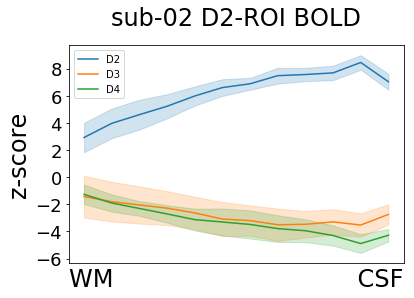

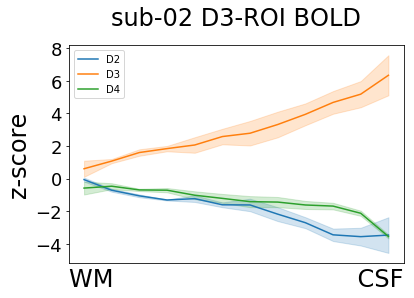

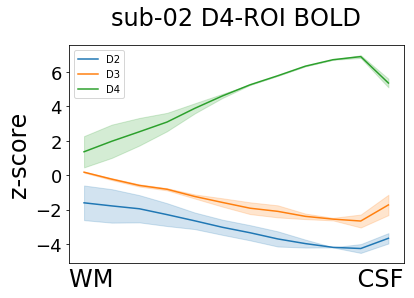

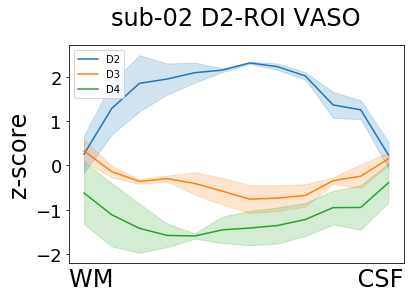

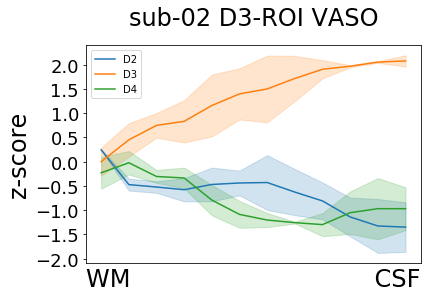

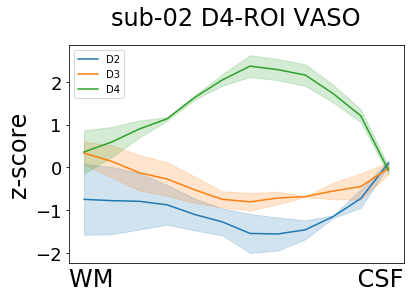

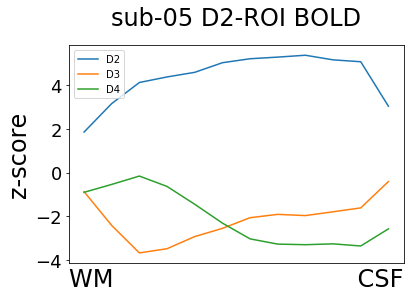

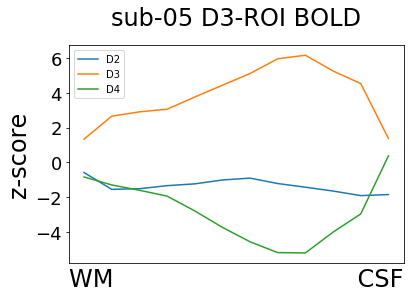

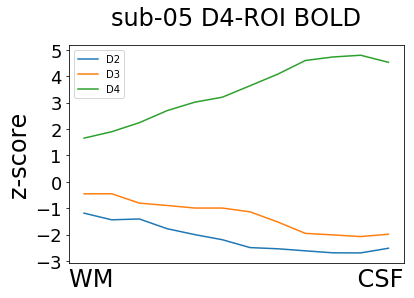

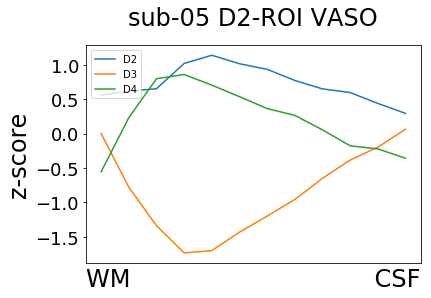

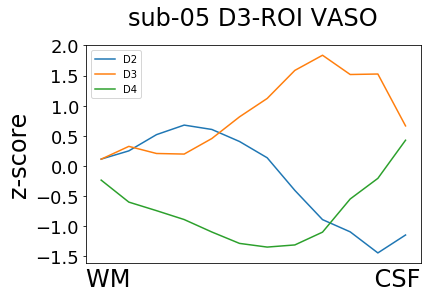

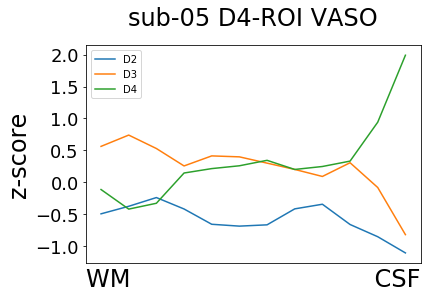

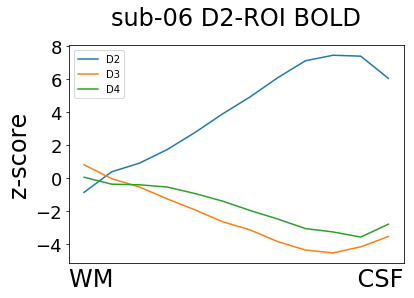

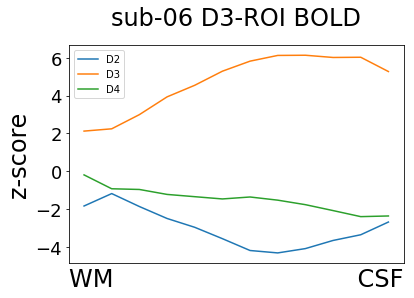

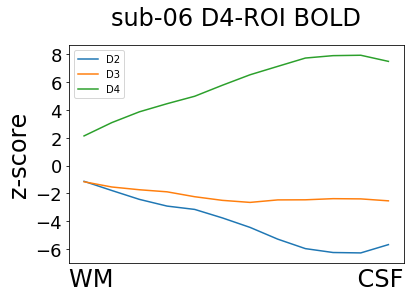

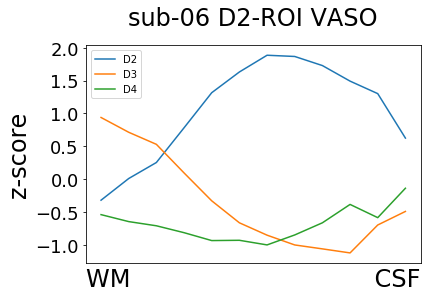

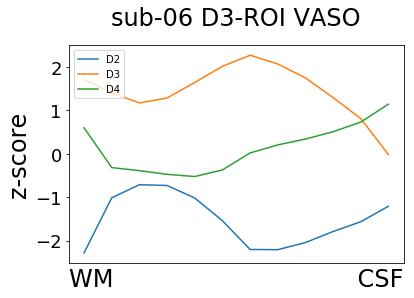

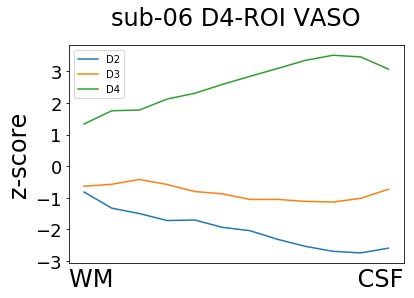

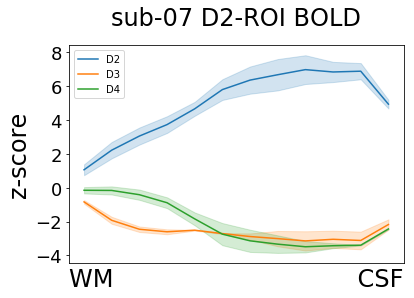

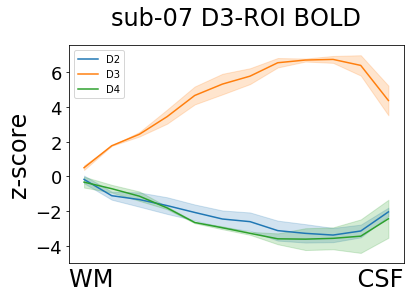

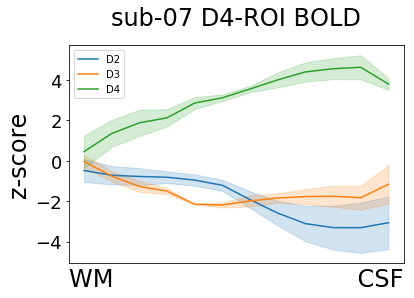

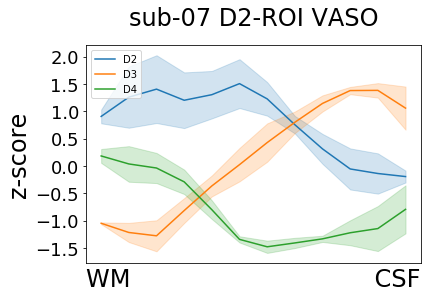

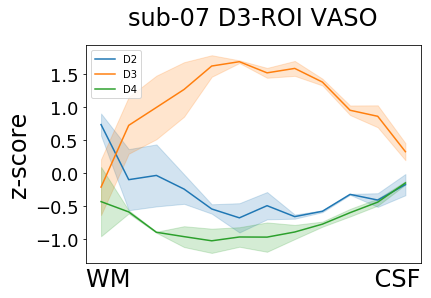

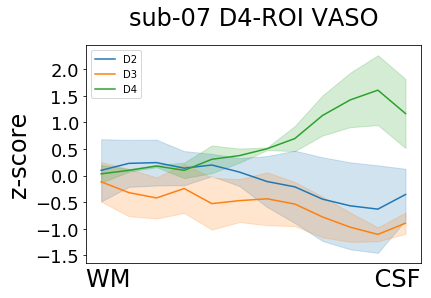

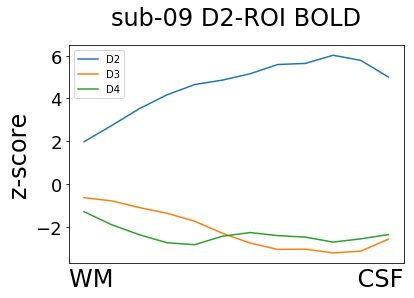

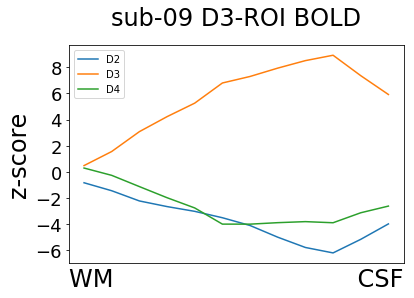

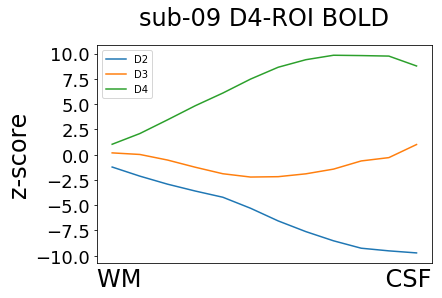

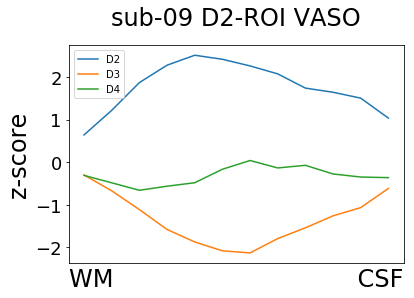

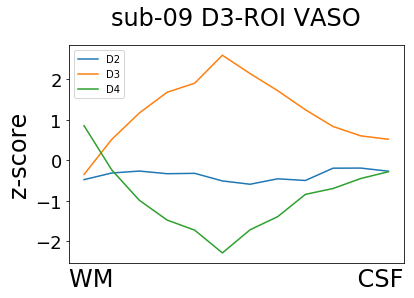

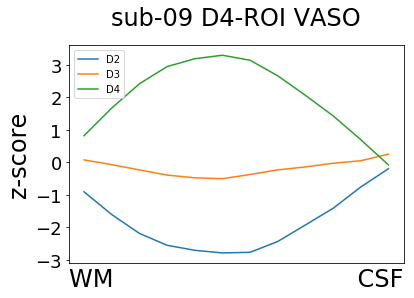

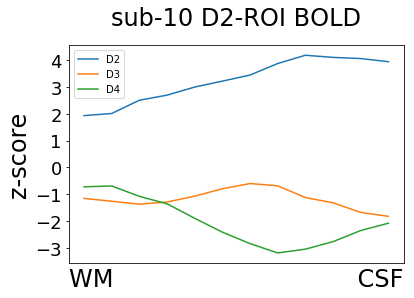

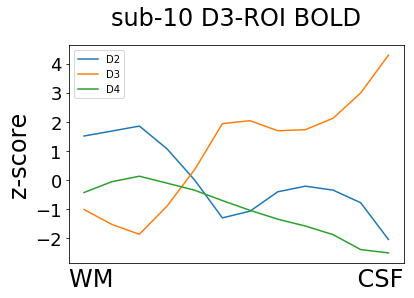

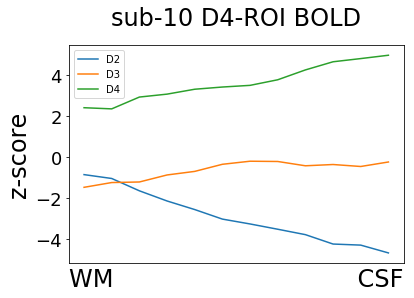

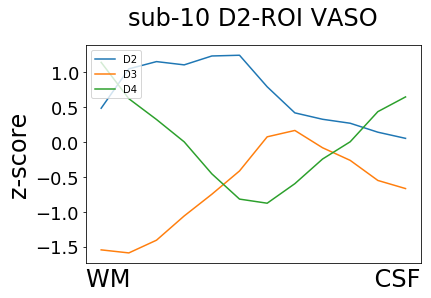

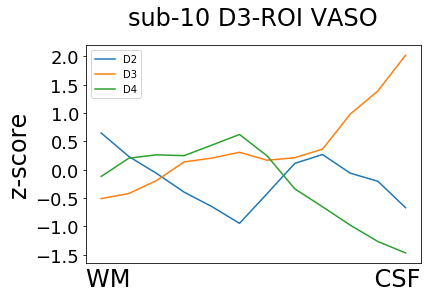

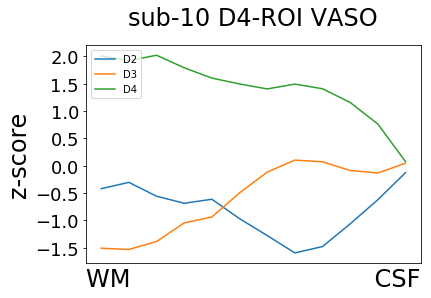

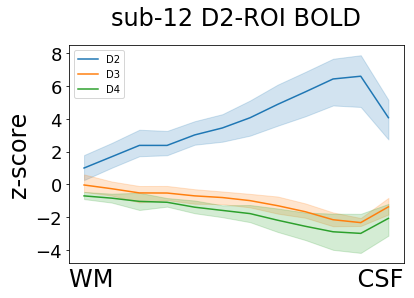

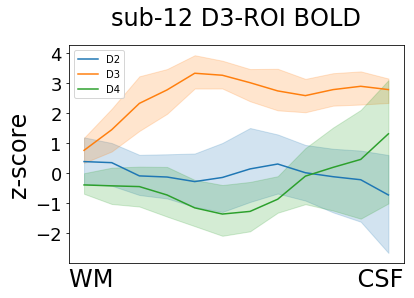

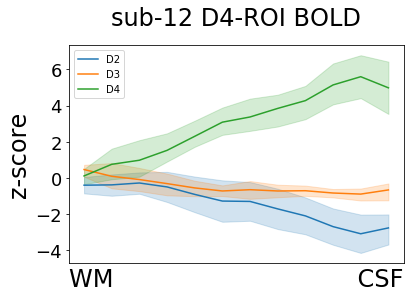

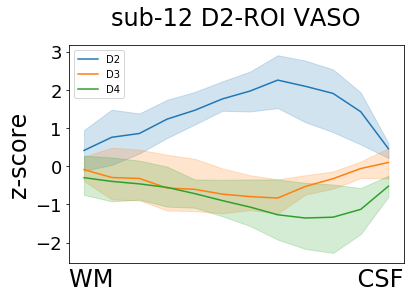

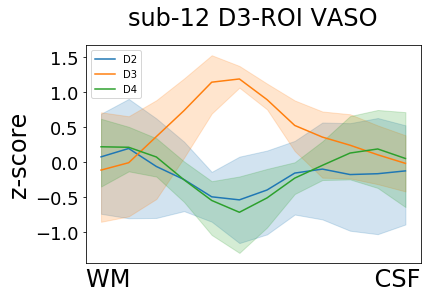

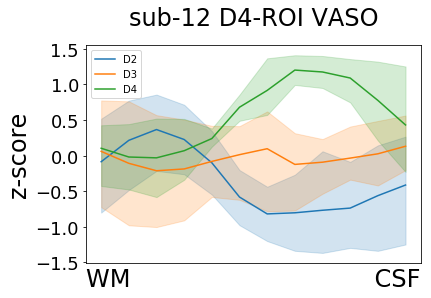

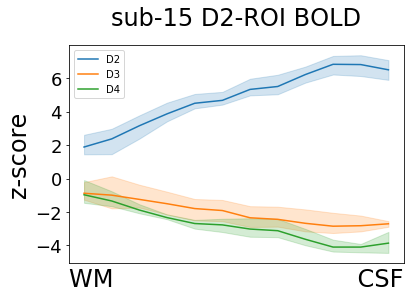

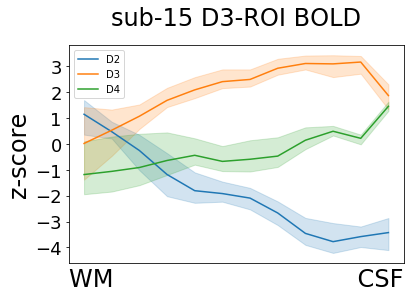

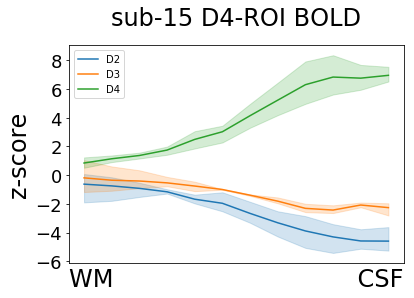

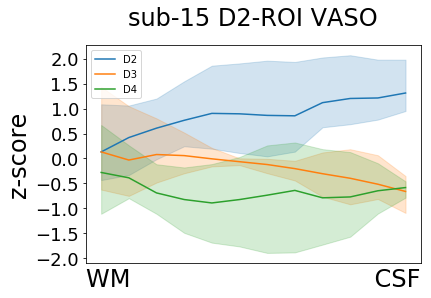

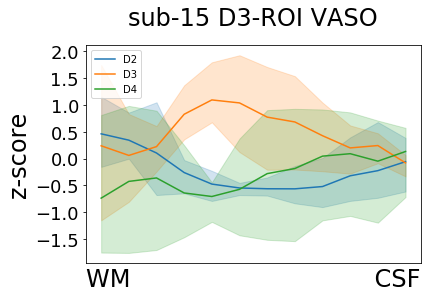

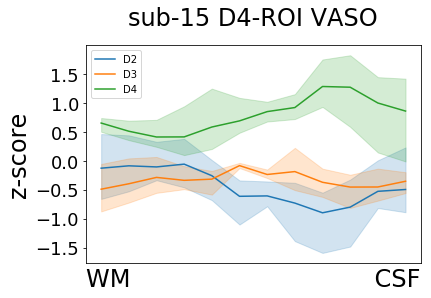

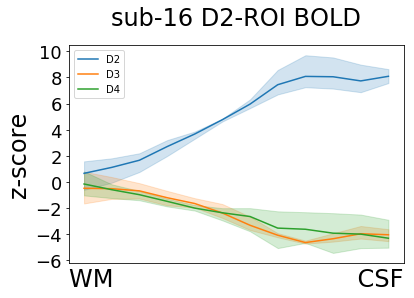

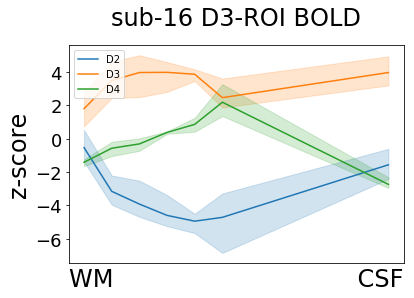

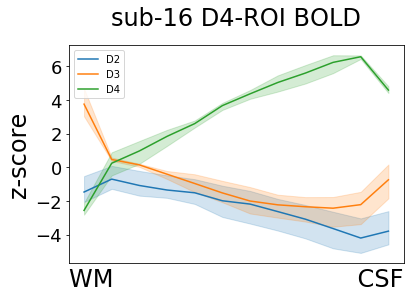

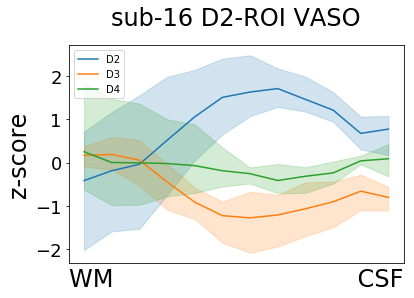

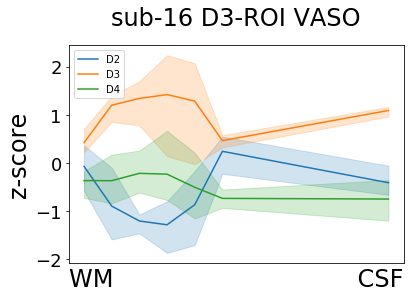

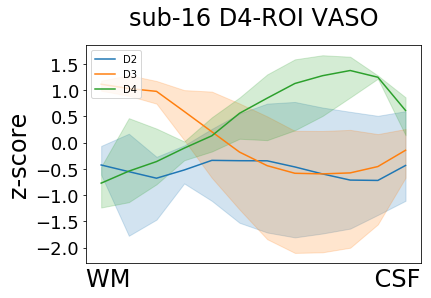

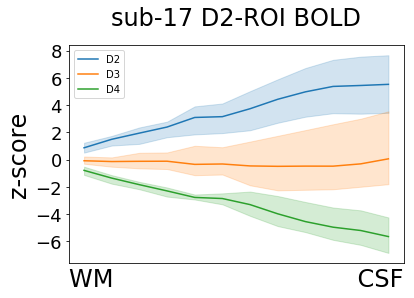

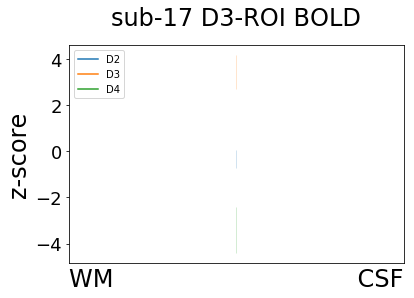

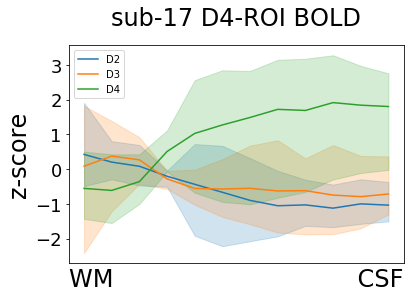

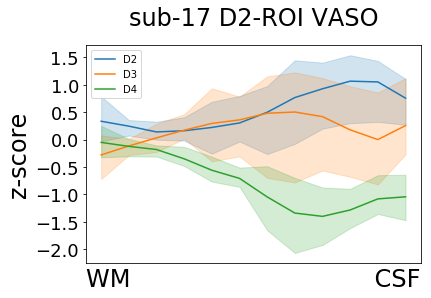

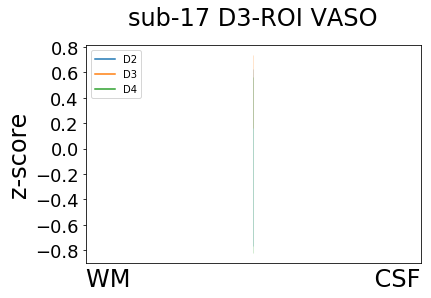

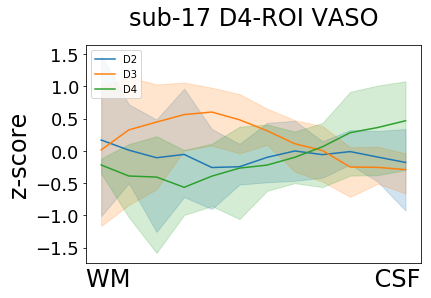

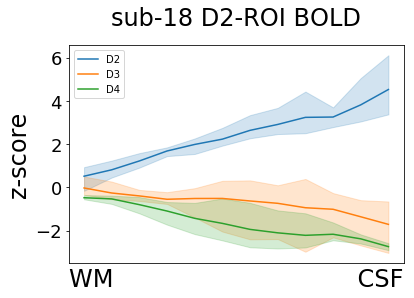

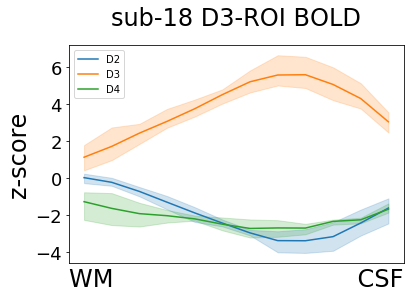

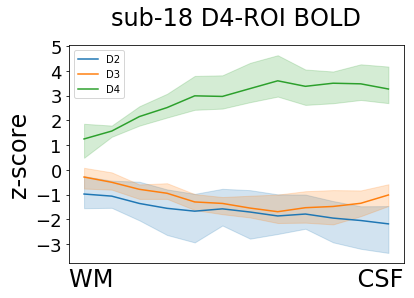

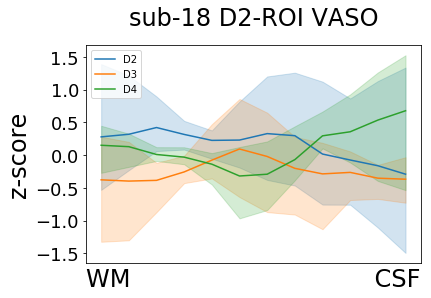

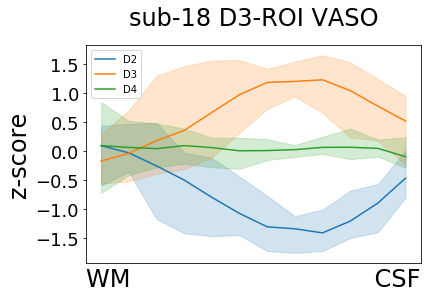

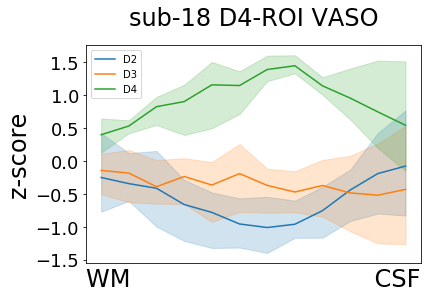

In [149]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots()

for sub in subs:
    for modality in ['BOLD','VASO']:

        for roi in digits:

            tmp = zscores.loc[(zscores['subject']==sub)&(zscores['modality']==modality)&(zscores['readROI']==roi)]

            sns.lineplot(data=tmp, x='layer', y='data', hue='stimDigit')


            plt.ylabel(f'z-score', fontsize=24)

            plt.title(f"{sub} {roi}-ROI {modality}", fontsize=24, pad=20)
            plt.xlabel('WM                                CSF', fontsize=24)
            plt.xticks([])
            yLimits = ax.get_ylim()
            # plt.ylim(0,yLimits[1])    

            plt.yticks(fontsize=18)

            ax.yaxis.set_major_locator(MaxNLocator(integer=True))

            plt.legend(loc='upper left')


            # plt.savefig(f'{root}/Group_V1_{stimType}_zScoreProfile.png', bbox_inches = "tight")
            plt.show()

Text(25.4168,0.5,'bold_zstat')

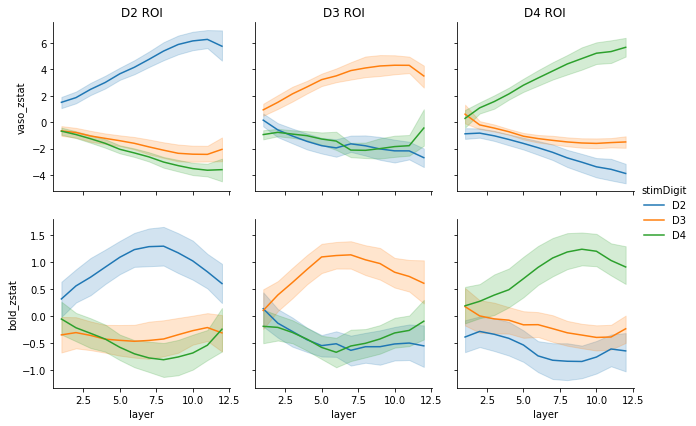

In [10]:
g = sns.FacetGrid(zscores, col="readROI", row="modality",hue = 'stimDigit', sharey="row")
g = g.map(sns.lineplot, 'layer', 'data').add_legend()
g.axes[0,0].set_title("D2 ROI")
g.axes[0,1].set_title("D3 ROI")
g.axes[0,2].set_title("D4 ROI")

g.axes[1,0].set_title("")
g.axes[1,1].set_title("")
g.axes[1,2].set_title("")

axes = g.axes.flatten()
axes[0].set_ylabel("vaso_zstat")
axes[3].set_ylabel("bold_zstat")


#g.savefig('/Volumes/elements/data/s1_anfunco_analysis/groupresults/average_withvar.png')

### Digit vs rest

In [36]:
subList = []
dataList = []
modalityList = []
layerList = []
digitList = []
roiList = []


digitsMaps = {'D2': 4, 'D3': 5, 'D4': 6}
digits = ['D2', 'D3', 'D4']



for sub in subs:    
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-stim_run-00*_cbv.nii.gz'))

    for run in runs:

        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        print(base)
        
        for modality in ['BOLD','VASO']:
            
                
            for roi in digitsMaps.keys():
                mask = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{roi}_12_layers_equivol.nii').get_fdata()
                
                for digit in digits:
                    
                    data = nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.feat/stats/zstat{digitsMaps[digit]}_scaled.nii.gz').get_fdata()



                    for j in range(1,13):  # Compute bin averages
                        
                        
                        layerRoi = mask == j
                        
                        mask_mean = np.mean(data[layerRoi.astype(bool)])

                        subList.append(sub)
                        dataList.append(mask_mean)
                        modalityList.append(modality)
                        layerList.append(j)
                        digitList.append(digit)
                        roiList.append(roi)



            
zscoresVSrest = pd.DataFrame({'subject': subList, 'data': dataList, 'modality': modalityList, 'layer':layerList, 'stimDigit':digitList, 'readROI': roiList})

sub-02_ses-003_task-stim_run-001


/home/sebastian/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/home/sebastian/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



sub-02_ses-003_task-stim_run-002
sub-05_ses-002_task-stim_run-001
sub-06_ses-001_task-stim_run-001
sub-07_ses-001_task-stim_run-001
sub-07_ses-001_task-stim_run-002
sub-09_ses-001_task-stim_run-001
sub-10_ses-001_task-stim_run-001
sub-12_ses-001_task-stim_run-001
sub-12_ses-001_task-stim_run-002
sub-12_ses-001_task-stim_run-003
sub-12_ses-001_task-stim_run-004
sub-15_ses-001_task-stim_run-001
sub-15_ses-001_task-stim_run-002
sub-15_ses-001_task-stim_run-003
sub-16_ses-001_task-stim_run-001
sub-16_ses-001_task-stim_run-002
sub-16_ses-001_task-stim_run-003
sub-17_ses-001_task-stim_run-001
sub-17_ses-001_task-stim_run-002
sub-17_ses-001_task-stim_run-003
sub-18_ses-001_task-stim_run-001
sub-18_ses-001_task-stim_run-002
sub-18_ses-001_task-stim_run-003


Text(25.4168,0.5,'bold_zstat')

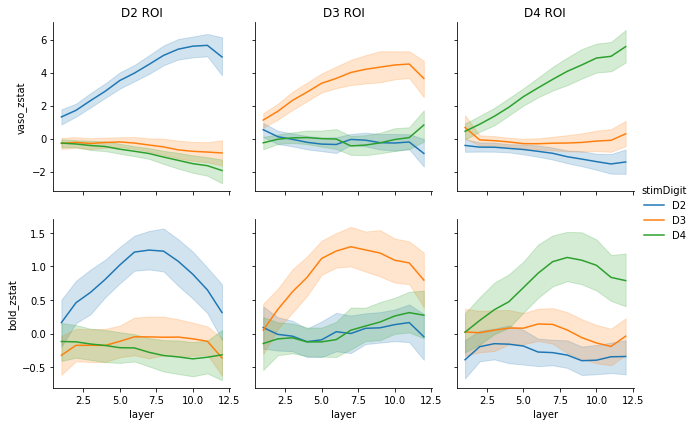

In [37]:
g = sns.FacetGrid(zscoresVSrest, col="readROI", row="modality",hue = 'stimDigit', sharey="row")
g = g.map(sns.lineplot, 'layer', 'data').add_legend()
g.axes[0,0].set_title("D2 ROI")
g.axes[0,1].set_title("D3 ROI")
g.axes[0,2].set_title("D4 ROI")

g.axes[1,0].set_title("")
g.axes[1,1].set_title("")
g.axes[1,2].set_title("")

axes = g.axes.flatten()
axes[0].set_ylabel("vaso_zstat")
axes[3].set_ylabel("bold_zstat")


#g.savefig('/Volumes/elements/data/s1_anfunco_analysis/groupresults/average_withvar.png')

In [ ]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots()

    for modality in ['VASO']:

        for roi in digits:

            tmp = zscores.loc[(zscores['subject']==sub)&(zscores['modality']==modality)&(zscores['readROI']==roi)]

            sns.lineplot(data=tmp, x='layer', y='data', hue='stimDigit')


            plt.ylabel(f'z-score', fontsize=24)

            plt.title(f"{sub} {roi}-ROI {modality}", fontsize=24, pad=20)
            plt.xlabel('WM                                CSF', fontsize=24)
            plt.xticks([])
            yLimits = ax.get_ylim()
            # plt.ylim(0,yLimits[1])    

            plt.yticks(fontsize=18)

            ax.yaxis.set_major_locator(MaxNLocator(integer=True))

            plt.legend(loc='upper left')


            # plt.savefig(f'{root}/Group_V1_{stimType}_zScoreProfile.png', bbox_inches = "tight")
            plt.show()

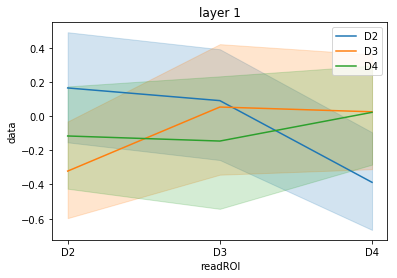

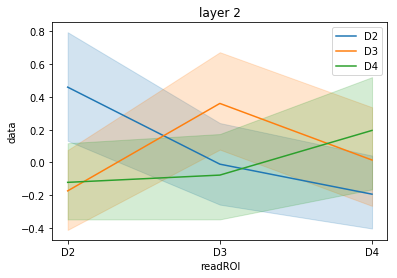

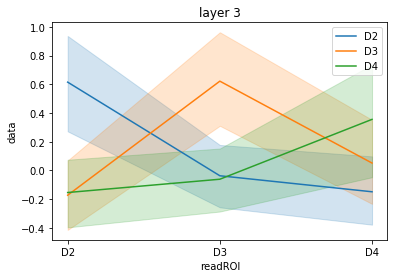

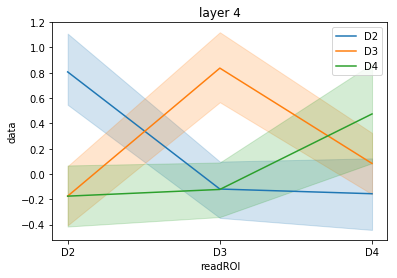

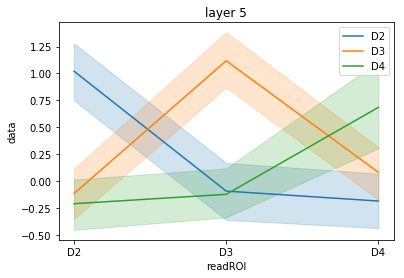

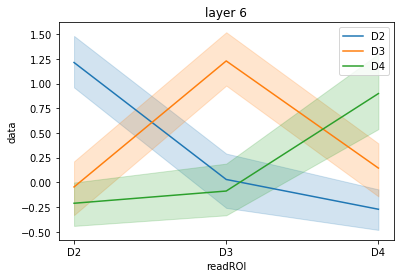

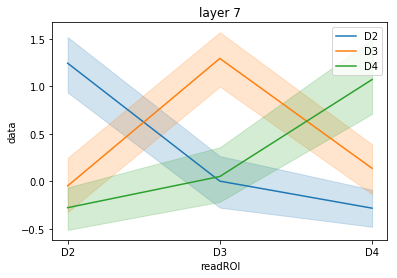

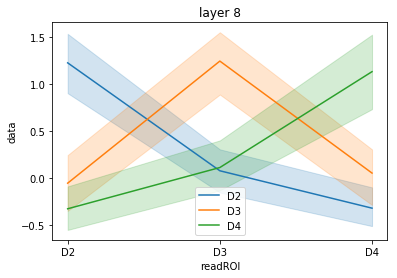

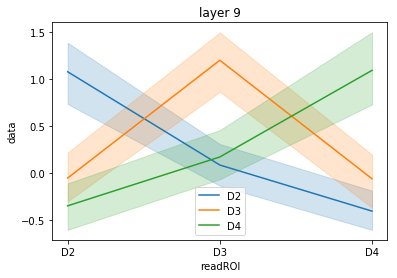

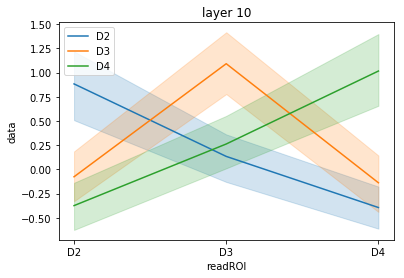

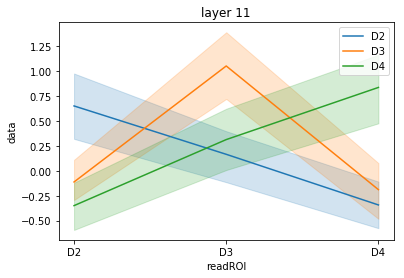

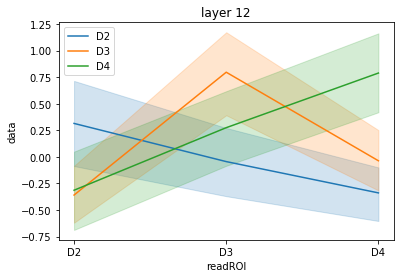

In [43]:


for layer in zscoresVSrest['layer'].unique():
    fig, ax = plt.subplots()


    for modality in ['VASO']:

        sns.lineplot(data=zscoresVSrest.loc[(zscoresVSrest['modality']==modality)&(zscoresVSrest['layer']==layer)], x='readROI', y='data', hue='stimDigit')
        plt.legend()
        plt.title(f'layer {layer}')

### Plot voxel specificity

In [13]:
def find_roi_box(array):

    smallestx = 1000
    largestx = 0

    smallesty = 1000
    largesty = 0

    smallestz = 1000
    largestz = 0

    for n in range(array.shape[-1]):
        for i in range(array.shape[-2]):
            indexes = np.nonzero(array[:,i,n])[0]


            if indexes.size != 0:

                if indexes[0] < smallestx:
                    smallestx=indexes[0]
                if indexes[-1] > largestx:
                    largestx=indexes[-1]

                if n < smallestz:
                    smallestz=n
                if n > largestz:
                    largestz=n


        for i in range(array.shape[0]):
            indexes = np.nonzero(array[i,:,n])[0]


            if indexes.size != 0:

                if indexes[0] < smallesty:
                    smallesty=indexes[0]
                if indexes[-1] > largesty:
                    largesty=indexes[-1]

    x_idx_range = slice(smallestx-1, largestx+1)
    y_idx_range = slice(smallesty-1, largesty+1)
    z_idx_range = slice(smallestz-1, largestz+1)

    return (x_idx_range, y_idx_range, z_idx_range)

In [109]:
subList = []
roiList = []
scoresList = []
stimList = []

for sub in subs[:1]:    
    
    runs = sorted(glob.glob(f'{root}/{sub}/ses-00*/func/{sub}_ses-00*_task-stim_run-00*_cbv.nii.gz'))

    for run in runs:

        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        print(base)
        
        for modality in ['VASO']:
            
                
            for roi in digitsMaps.keys():
                
                mask = nb.load(f'{root}/derivatives/{sub}/anat/{sub}_{roi}_12_layers_equivol.nii').get_fdata()
                idx_mask = mask == 6
                                
                box = find_roi_box(mask)
                
                
                for digit in digits:
                    data = nb.load(f'{root}/derivatives/{sub}/func/{base}_{modality}.feat/stats/zstat{digitsMaps[digit]}_scaled.nii.gz').get_fdata()


                    norm_depth_roi = norm_depth[idx_mask]
                    dataArr = data[idx_mask]
                    
                    for item in dataArr:
                        subList.append(sub)
                        roiList.append(roi)
                        scoresList.append(item)
                        stimList.append(digit)
                        
                    
                
                
                
                
                
                
                
                
                

sub-02_ses-003_task-stim_run-001
sub-02_ses-003_task-stim_run-002


In [110]:
test = pd.DataFrame({'subject': subList, 'roi':roiList,'scores':scoresList, 'digitStim':stimList})

In [111]:
%matplotlib inline

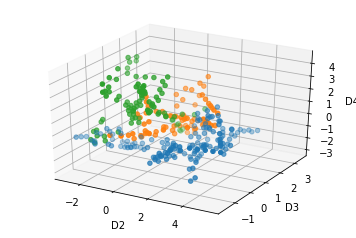

In [112]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')


for roi in digits:
    

    x = test.loc[(test['roi']==roi)&(test['digitStim'] == 'D2')]['scores'].tolist()
    y = test.loc[(test['roi']==roi)&(test['digitStim'] == 'D3')]['scores'].tolist()
    z = test.loc[(test['roi']==roi)&(test['digitStim'] == 'D4')]['scores'].tolist()

    ax.set_xlabel("D2")
    ax.set_ylabel("D3")
    ax.set_zlabel("D4")
    
    
    
    
    ax.scatter(x, y, z, cmap=cmap)

plt.show()